In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import and Data Preparation

In [82]:
path = "/content/drive/Shareddrives/DATA 245 - ML/cleaned_SF_crime_report.csv"

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.io.formats.info import DataFrameTableBuilderVerbose
from sklearn.preprocessing import OrdinalEncoder

In [84]:
df = pd.read_csv(path)
pd.set_option('display.max_columns',None)
df = df.iloc[:-100000,:]

In [85]:
len(df[df['Police_District'] == 'Out of SF'])

4590

In [86]:
df.head()

,Incident_Date,Incident_Time,Incident_Day_of_Week,Report_Datetime,Row_ID,Incident_ID,Incident_Number,Report_Type_Code,Report_Type_Description,Filed_Online,Incident_Code,Incident_Category,Incident_Subcategory,Incident_Description,Resolution,CNN,Police_District,Analysis_Neighborhood,Supervisor_District,Latitude,Longitude
0,2019/03/05,21:00,Tuesday,2019/03/07 12:54:00 PM,77808706372,778087,196048512,II,Coplogic Initial,True,6372,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Open or Active,30044000.0,Tenderloin,Tenderloin,6.0,37.779992,-122.413487
1,2018/12/22,12:00,Saturday,2018/12/26 02:29:00 PM,75246907023,752469,180971777,VI,Vehicle Initial,False,7023,Motor Vehicle Theft,Motor Vehicle Theft,"Vehicle, Stolen, Motorcycle",Open or Active,25931000.0,Northern,Hayes Valley,5.0,37.775787,-122.427819
2,2018/08/24,17:30,Friday,2018/08/24 07:35:00 PM,70675306243,706753,180639339,II,Initial,False,6243,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, $200-$950",Open or Active,21610000.0,Ingleside,Excelsior,9.0,37.723944,-122.422830
3,2018/10/20,15:10,Saturday,2018/10/20 03:10:00 PM,72826462071,728264,180624631,IS,Initial Supplement,False,62071,Warrant,Other,Probation Search,Cite or Arrest Adult,23914000.0,Southern,South of Market,6.0,37.775161,-122.403636
4,2019/06/05,00:36,Wednesday,2019/06/05 12:37:00 AM,80823030140,808230,190403077,II,Initial,False,30140,Other Offenses,Other,"Air Gun, Possession",Cite or Arrest Adult,30035000.0,Central,North Beach,3.0,37.802755,-122.413623


In [87]:
# seperate date and time
df['Year'] = df['Incident_Date'].apply(lambda x: int(x[0:4]))
df['Month'] = df['Incident_Date'].apply(lambda x: int(x[5:7]))
df['Day'] = df['Incident_Date'].apply(lambda x: int(x[8:10]))

df['Hour'] = df['Incident_Time'].apply(lambda x: int(x[0:2]))
df['Min'] = df['Incident_Time'].apply(lambda x: int(x[3:5]))

In [88]:
# drop columns
df.drop(columns=['Row_ID','Incident_ID','Incident_Number','Report_Type_Code','Report_Type_Description','Filed_Online','Incident_Code',
                'Incident_Subcategory','Incident_Description','Resolution','Report_Datetime','CNN','Police_District'], inplace=True)

In [89]:
len(set(df['Incident_Category']))

49

In [90]:
def time_of_day(hour):
    if hour >= 0 and hour < 4:
        return 'Late Night'
    elif hour >= 4 and hour < 6:
        return 'Dawn'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 20:
        return 'Evening'
    elif hour >= 20 and hour <= 23:
        return 'Night'

In [91]:
def business_hours(hours):
    return 8 <= hours <= 18

In [92]:
def third_of_month(day):
    if day >= 1 and day < 10:
        return '1st_third'
    elif day >= 10 and day < 20:
        return '2nd_third'
    elif day >= 20 and day <= 31:
        return '3rd_third'

In [93]:
def weekend(weekday):
    if weekday == "Saturday" or weekday == "Sunday":
        return True
    else:
        return False

In [94]:
def quarter_of_year(month):
    if month >= 1 and month <= 3:
        return '1st_quarter'
    elif month > 3 and month <= 6:
        return '2nd_quarter'
    elif month > 6 and month <= 9:
        return '3rd_quarter'
    elif month > 9 and month <= 12:
        return '4th_quarter'

In [95]:

df['Time_of_Day'] = df['Hour'].map(time_of_day)
df['Business Hours'] = df['Hour'].map(business_hours)
df['Business Hours'].value_counts()
#df['Third_of_Month'] = df['Day'].map(third_of_month)
df['Weekend'] = df['Incident_Day_of_Week'].map(weekend)
#df['Quarter_of_Year'] = df['Month'].map(quarter_of_year)
df["Incident_Date"] = pd.to_datetime(df["Incident_Date"], format="%Y-%m-%d %H:%M:%S")

cal = calendar()
holidays = cal.holidays(start=df['Incident_Date'].min(), end=df['Incident_Date'].max())
df['Holiday'] = df['Incident_Date'].dt.date.astype('datetime64').isin(holidays)
df.drop(columns = ['Year','Month','Day','Hour','Min','Incident_Date','Incident_Time','Supervisor_District'],inplace=True)

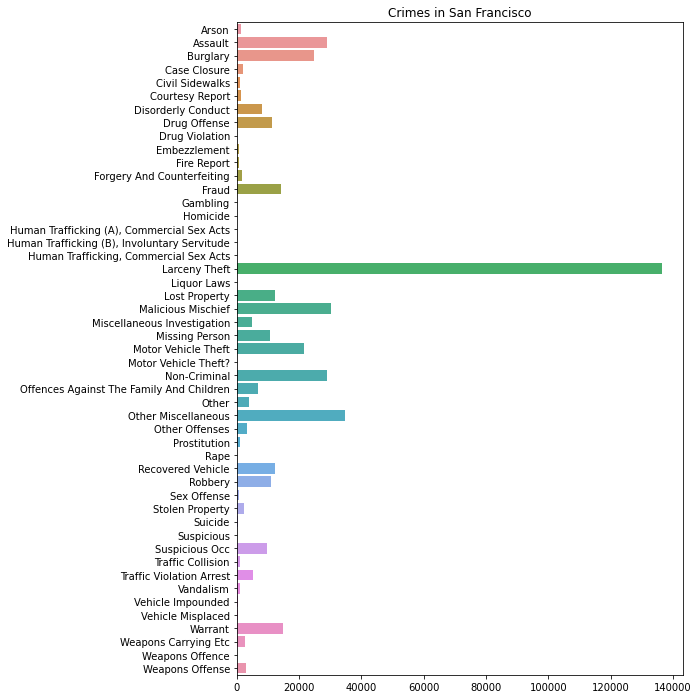

In [96]:

crime, freq = np.unique(df['Incident_Category'],return_counts = True)
fig, count = plt.subplots(figsize = (8,12))
count = sns.barplot(x = freq, y = crime)
count.set_title('Crimes in San Francisco')  
plt.show()

In [97]:
# Reduce the categories       #'Larceny Theft', 'Other Miscellaneous', 'Recovered Vehicle', 'Lost Property', 'Non-Criminal', 'Warrant', Fraud, Burglary

violent = ['Burglary','Malicious Mischief','Assault','Missing Person','Rape','Human Trafficking (A), Commercial Sex Acts',
           'Homicide','Human Trafficking, Commercial Sex Acts']
Theft = ['Motor Vehicle Theft', 'Lost Property','Robbery','Larceny Theft']
Other = ['Non-Criminal','Warrant','Fraud','Drug Offense','Suspicious Occ','Other Miscellaneous','Recovered Vehicle']

# Low = ['Recovered Vehicle','Lost Property','Non-Criminal']
# Bad = ['Warrant','Fraud','Assault']

#df.replace(['Beer','Alcohol','Beverage','Drink'],'Drink', inplace=True)  'Larceny Theft',

df.replace(['Burglary','Malicious Mischief','Assault','Missing Person'], 'Violent',inplace=True)
df.replace(['Motor Vehicle Theft', 'Lost Property','Robbery','Larceny Theft'], 'Theft',inplace=True)
df.replace(['Non-Criminal','Warrant','Fraud','Drug Offense','Suspicious Occ','Other Miscellaneous'], 'Other',inplace=True)

In [98]:

df = df.loc[df['Incident_Category'].isin(['Theft','Violent','Other'])]
df.reset_index(inplace=True)
df.drop(columns=['index'],inplace=True)

In [99]:
#df.to_csv('MLdata.csv')

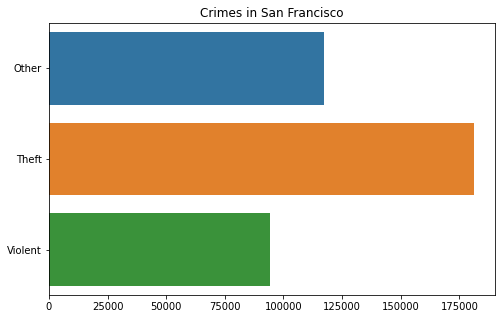

In [100]:
crime, freq = np.unique(df['Incident_Category'],return_counts = True)
fig, count = plt.subplots(figsize = (8,5))
count = sns.barplot(x = freq, y = crime)
count.set_title('Crimes in San Francisco')  
plt.show()

In [101]:
import warnings
warnings.filterwarnings("ignore")

enc = OrdinalEncoder()
df['Analysis_Neighborhood'] = enc.fit_transform(df[['Analysis_Neighborhood']])
df['Business Hours'] = enc.fit_transform(df[['Business Hours']])
df['Holiday'] = enc.fit_transform(df[['Holiday']])
df['Incident_Day_of_Week'] = enc.fit_transform(df[['Incident_Day_of_Week']])
#df['Quarter_of_Year'] = enc.fit_transform(df['Quarter_of_Year'])
#df['Report_Type_Code'] = enc.fit_transform(df['Report_Type_Code'])
#df['Supervisor_District'] = enc.fit_transform(df['Supervisor_District'])
#df['Third_of_Month'] = enc.fit_transform(df['Third_of_Month'])
df['Weekend'] = enc.fit_transform(df[['Weekend']])
df['Incident_Category'] = enc.fit_transform(df[['Incident_Category']])

df['Time_of_Day'] = enc.fit_transform(df[['Time_of_Day']])

In [102]:
#df.to_csv('ml_data.csv')

# Preprocessing and Modelling

In [103]:
import pickle

In [104]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, matthews_corrcoef, log_loss, f1_score
from sklearn.decomposition import PCA, TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score,recall_score

In [105]:
# Split the data
X = df.loc[:, df.columns != 'Incident_Category']
y = df['Incident_Category']

In [106]:
# y = label_binarize(y, classes=[0, 1, 2])
# n_classes = y.shape[1]

In [107]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [108]:
np.unique(y,return_counts=True)

(array([0., 1., 2.]), array([181285, 181285, 181285]))

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((380698, 8), (163157, 8))

In [110]:
# Scaling the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [111]:
# y_train = np.array(y_train) 
# y_test = np.array(y_test)

# KNN

In [112]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [113]:
y_pred = knn.predict(X_test)
test_acc = accuracy_score(y_pred,y_test)
print('test accuracy=',test_acc)

test accuracy= 0.5153073420080045


In [115]:
precision_score(y_test, y_pred, average=None)

array([0.48365775, 0.52918138, 0.54726149])

In [117]:
recall_score(y_test, y_pred, average=None)

array([0.61210915, 0.45500718, 0.47906201])

In [116]:
precision_score(y_test, y_pred, average='macro')

0.5200335418660643

In [118]:
recall_score(y_test, y_pred, average='macro')

0.5153927786367062

In [114]:
test_f1 = f1_score(y_pred,y_test,average='macro')
test_f1

0.5135165257976017

In [119]:
Pkl_Filename = "Pickle_KNN_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(knn, file)

# Navie Bayes

In [120]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [121]:
y_pred = nb.predict(X_test)
y_ptrain = nb.predict(X_train)

In [122]:
test_acc = accuracy_score(y_pred,y_test)
train_acc = accuracy_score(y_ptrain,y_train)
print('train accuracy=',train_acc, 'test accuracy=',test_acc)

train accuracy= 0.3934430966277732 test accuracy= 0.3949692627346666


In [124]:
precision_score(y_test, y_pred, average=None)

array([0.39634506, 0.41392244, 0.38463297])

In [126]:
recall_score(y_test, y_pred, average=None)

array([0.4331804 , 0.25790365, 0.49350959])

In [125]:
precision_score(y_test, y_pred, average='macro')

0.3983001587200968

In [127]:
recall_score(y_test, y_pred, average='macro')

0.3948645463300553

In [123]:
test_f1 = f1_score(y_pred,y_test,average='macro')
test_f1

0.38802115988322944

In [128]:
Pkl_Filename = "Pickle_NB_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(nb, file)

# Decision tree

In [129]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [130]:
clf = clf.fit(X_train, y_train)

In [131]:
y_pred = clf.predict(X_test)
print('Decision tree accuracy score',accuracy_score(y_pred,y_test))

Decision tree accuracy score 0.5308077495908848


In [133]:
precision_score(y_test, y_pred, average=None)

array([0.50567264, 0.53396513, 0.56198685])

In [135]:
recall_score(y_test, y_pred, average=None)

array([0.57651134, 0.56195944, 0.45429211])

In [134]:
precision_score(y_test, y_pred, average='macro')

0.5338748716858824

In [136]:
recall_score(y_test, y_pred, average='macro')

0.5309209626776271

In [132]:
test_f1 = f1_score(y_pred,y_test,average='macro')
test_f1

0.5296038347203597

In [137]:
Pkl_Filename = "Pickle_DT_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

# Random Forest 

In [138]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [139]:
y_pred = rf.predict(X_test)
test_acc = accuracy_score(y_pred,y_test)
test_acc

0.5499978548269459

In [144]:
test_f1 = f1_score(y_pred,y_test,average='macro')
test_f1

0.5499633943149184

In [141]:
precision_score(y_test, y_pred, average=None)

array([0.55212159, 0.53685454, 0.56222291])

In [142]:
precision_score(y_test, y_pred, average='macro')

0.5503996796823968

In [143]:
recall_score(y_test, y_pred, average=None)

array([0.55957843, 0.56037687, 0.53012357])

In [145]:
recall_score(y_test, y_pred, average='macro')

0.5500262914909545

In [146]:
Pkl_Filename = "Pickle_rf_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(rf, file)

## creating ROC curve for random forest

In [149]:
y_test_arr = label_binarize(y_test, classes=[0, 1, 2])
y_pred_arr = label_binarize(y_pred, classes=[0, 1, 2])
n_classes = y_test_arr[1]

In [150]:
# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr[:, i], y_pred_arr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_arr.ravel(), y_pred_arr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

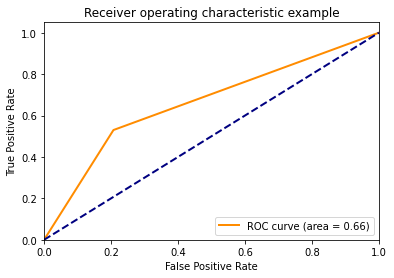

In [151]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

#Applying K fold to decision tree

In [152]:
kf = KFold(n_splits=10)
test_acc_arr=[]
test_f1_arr= []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred = clf.predict(X_test)
    train_acc = round(accuracy_score(y_pred_train,y_train),3)
    test_acc = round(accuracy_score(y_pred,y_test),3)
    test_acc_arr.append(test_acc)
    test_f1 = round(f1_score(y_pred,y_test,average='weighted'),3)
    test_f1_arr.append(test_f1)
    test_pres= round(precision_score(y_test, y_pred, average='weighted'),3)
    print('test accuracy=',train_acc,'\ttest accuracy=',test_acc,'\ttest f1 score=',test_f1,'\tprecision score',test_pres)
    print('\n')

TRAIN: [ 54386  54387  54388 ... 543852 543853 543854] TEST: [    0     1     2 ... 54383 54384 54385]
test accuracy= 0.783 	test accuracy= 0.508 	test f1 score= 0.507 	precision score 0.514


TRAIN: [     0      1      2 ... 543852 543853 543854] TEST: [ 54386  54387  54388 ... 108769 108770 108771]
test accuracy= 0.782 	test accuracy= 0.5 	test f1 score= 0.499 	precision score 0.507


TRAIN: [     0      1      2 ... 543852 543853 543854] TEST: [108772 108773 108774 ... 163155 163156 163157]
test accuracy= 0.782 	test accuracy= 0.493 	test f1 score= 0.493 	precision score 0.498


TRAIN: [     0      1      2 ... 543852 543853 543854] TEST: [163158 163159 163160 ... 217541 217542 217543]
test accuracy= 0.781 	test accuracy= 0.506 	test f1 score= 0.505 	precision score 0.515


TRAIN: [     0      1      2 ... 543852 543853 543854] TEST: [217544 217545 217546 ... 271927 271928 271929]
test accuracy= 0.783 	test accuracy= 0.505 	test f1 score= 0.506 	precision score 0.508


TRAIN: [     

In [159]:
print("%0.3f accuracy with a standard deviation of %0.3f" % (np.mean(test_acc_arr),np.std(test_acc_arr)))

0.514 accuracy with a standard deviation of 0.035


In [158]:
print("%0.3f F1 score with a standard deviation of %0.3f" % (np.mean(test_acc_arr),np.std(test_acc_arr)))

0.514 F1 score with a standard deviation of 0.035


#SVC

Downsampling dataset to balance dataset and reduce computation time

In [160]:
from sklearn.utils import resample

In [162]:
#speraring disfferent labels to different dataframes 
df_0 = df.loc[df['Incident_Category'] == 0]
df_1 = df.loc[df['Incident_Category'] == 1]
df_2 = df.loc[df['Incident_Category'] == 2]

In [163]:
df_0_down = resample(df_0,replace=False,n_samples=25000)
df_1_down = resample(df_1,replace=False,n_samples=25000)
df_2_down = resample(df_2,replace=False,n_samples=25000)

In [164]:
df_new = pd.concat([df_0_down, df_1_down, df_2_down])

In [165]:
# Split the data
X = df_new.loc[:, df.columns != 'Incident_Category']
y = df_new['Incident_Category']

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train.shape, X_test.shape

((52500, 8), (22500, 8))

In [167]:
# Scaling the data

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [168]:
svd = TruncatedSVD(n_components=4, algorithm='randomized',random_state=0)
X_svd_train = svd.fit_transform(X_train)
X_svd_test  = svd.fit_transform(X_test)

In [169]:
pca = PCA(n_components=3)
X_pca = pca.fit(X_train)
X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)

In [170]:
from sklearn.svm import SVR, SVC
svc = SVC(kernel='linear',C=1)
svc.fit(X_svd_train,y_train)

SVC(C=1, kernel='linear')

In [172]:
y_pred=svc.predict(X_svd_test)
accuracy_score(y_test,y_pred)

0.37951111111111113

In [171]:
from sklearn.svm import SVC
svc_rbf = SVC(kernel='rbf',C=1)
svc_rbf.fit(X_svd_train,y_train)

SVC(C=1)

In [173]:
y_pred=svc_rbf.predict(X_svd_test)
accuracy_score(y_test,y_pred)

0.3992

In [174]:
svc_rbf_pca = SVC(kernel='rbf',C=1)
svc_rbf_pca.fit(X_pca_train,y_train)

SVC(C=1)

In [175]:
y_pred=svc_rbf_pca.predict(X_pca_test)
accuracy_score(y_test,y_pred)

0.3970666666666667

In [176]:
svc_rbf_pca = SVC(kernel='linear')
svc_rbf_pca.fit(X_pca_train,y_train)

SVC(kernel='linear')

In [177]:
y_pred=svc_rbf_pca.predict(X_pca_test)
accuracy_score(y_test,y_pred)

0.36862222222222224

In [ ]:
# svc is performing best for 

# Recalling pickle files for demo

In [ ]:
# KNN- Load the Model back from file
Pkl_Filename = "Pickle_KNN_Model.pkl" 
with open(Pkl_Filename, 'rb') as file:  
    Pickled_KNN_Model = pickle.load(file)

In [ ]:
y_pred = Pickled_RF_Model.predict(X_test)
test_acc = accuracy_score(y_pred,y_test)
test_acc

In [147]:
# Random forest Load the Model back from file
Pkl_Filename = "Pickle_rf_Model.pkl" 
with open(Pkl_Filename, 'rb') as file:  
    Pickled_RF_Model = pickle.load(file)

In [148]:
y_pred = Pickled_RF_Model.predict(X_test)
test_acc = accuracy_score(y_pred,y_test)
test_acc

0.5499978548269459